# Import

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Display Heatmap

In [2]:
def display_heatmap(image, u_matrix, num_clusters):
    """
    Affiche une carte de chaleur (heatmap) des degrés d'appartenance à chaque cluster.

    Parameters:
    image (ndarray): L'image d'origine en niveaux de gris.
    u_matrix (ndarray): La matrice des degrés d'appartenance des pixels aux clusters.
    num_clusters (int): Le nombre de clusters.

    Returns:
    None: Affiche une figure avec une heatmap des degrés d'appartenance pour chaque cluster.
    """
    
    fig = plt.figure(figsize=(20, 10))  # Taille ajustée pour l'affichage
    plt.suptitle("Heatmaps des Degrés d'Appartenance aux Clusters", fontsize=20)
    
    # Création de la grille de sous-graphiques
    gs = fig.add_gridspec(1, num_clusters, wspace=0.2, hspace=0.1)
    
    # Pour stocker la référence à la dernière image affichée (pour la colorbar)
    last_img = None

    # Afficher une heatmap pour chaque cluster
    for cluster_id in range(num_clusters):
        ax = fig.add_subplot(gs[0, cluster_id])
        segmentation_map = u_matrix[cluster_id].reshape(image.shape[0], image.shape[1])
        
        last_img = ax.imshow(segmentation_map, cmap="hot")
        ax.set_title(f"Cluster {cluster_id + 1}", fontsize=15)
        
        # Supprimer les axes pour une présentation plus claire
        ax.axis('off')

    # Ajout d'une barre de couleur commune
    cbar = fig.colorbar(last_img, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Degré d’appartenance', fontsize=12)
    
    plt.show()

# Fuzzy C Means

## Initialize Membership Matrix

In [3]:
def initialize_membership_matrix(img_shape, n_clusters):
    """
    Initialise la matrice d'appartenance.

    Parameters:
    img_shape (tuple): Dimensions de l'image sous forme (hauteur, largeur).
    n_clusters (int): Nombre de clusters.

    Returns:
    ndarray: Matrice d'appartenance initiale (U(0)) de forme (n_clusters, nombre_de_pixels).
    """
    # Calculer le nombre total de pixels
    num_pixels = img_shape[0] * img_shape[1]
    
    # Générer une matrice de Dirichlet aléatoire pour n_clusters et num_pixels
    return np.random.dirichlet(np.ones(n_clusters), size=num_pixels).T

## Updates

### Grayscale

In [4]:
# Calcul des centres de clusters (c_j) selon l'équation donnée
def update_centroids(img_flat, membership_matrix, m):
    """
    Met à jour les centres des clusters.

    Parameters:
    img_flat (ndarray): Image aplatie.
    membership_matrix (ndarray): La matrice d'appartenance des pixels aux clusters.
    m (float): La fuzziness.

    Returns:
    ndarray: Un tableau contenant les nouveaux centres de chaque cluster.
    """
    num = np.dot(membership_matrix**m, img_flat)  # Numérateur
    denom = np.sum(membership_matrix**m, axis=1)  # Dénominateur
    return num / denom

# Mise à jour de la matrice d'appartenance (U)
def update_membership_matrix(img_flat, centroids, m):
    """
    Met à jour la matrice d'appartenance.

    Parameters:
    img_flat (ndarray): Image aplatie.
    centroids (ndarray): Les centres des clusters.
    m (float): La fuzziness.

    Returns:
    ndarray: La matrice mise à jour d'appartenance des pixels aux clusters.
    """
    # Calcule les distances entre chaque pixel et chaque centre de cluster
    distances = np.array([np.abs(img_flat - c) + 1e-6 for c in centroids])
    
    # Calcule les puissances basées sur les distances
    powers = distances ** (-2.0 / (m - 1))
    
    # Normalise les puissances pour obtenir la matrice d'appartenance
    return powers / np.sum(powers, axis=0)

### RGB

In [5]:
# Calcul des centres de clusters (c_j) selon l'équation donnée
def update_centroids_rgb(img_flat, membership_matrix, m):
    """
    Met à jour les centres des clusters.

    Parameters:
    img_flat (ndarray): Image aplatie sur les trois canaux (nombre_de_pixels, 3).
    membership_matrix (ndarray): La matrice d'appartenance des pixels aux clusters.
    m (float): La fuzziness.

    Returns:
    ndarray: Un tableau contenant les nouveaux centres de chaque cluster (n_clusters, 3).
    """
    num = np.dot(membership_matrix**m, img_flat)  # Numérateur
    denom = np.sum(membership_matrix**m, axis=1, keepdims=True)  # Dénominateur
    return num / denom

# Mise à jour de la matrice d'appartenance (U)
def update_membership_matrix_rgb(img_flat, centroids, m):
    """
    Met à jour la matrice d'appartenance.

    Parameters:
    img_flat (ndarray): Image aplatie sur les trois canaux (nombre_de_pixels, 3).
    centroids (ndarray): Les centres des clusters (n_clusters, 3).
    m (float): La fuzziness.

    Returns:
    ndarray: Matrice mise à jour d'appartenance des pixels aux clusters (n_clusters, nombre_de_pixels).
    """
    # Calcule les distances euclidiennes entre chaque pixel et chaque centre de cluster
    distances = np.array([np.linalg.norm(img_flat - c, axis=1) + 1e-6 for c in centroids])
    
    # Calcule les puissances basées sur les distances
    powers = distances ** (-2.0 / (m - 1))
    
    # Normalise les puissances pour obtenir la matrice d'appartenance
    return powers / np.sum(powers, axis=0)

## Main Algorithm

### Grayscale

In [6]:
def fuzzy_c_means(img, n_clusters=2, m=2, max_iter=100, tol=1e-5):
    """
    Algorithme de Fuzzy C-Means pour la segmentation d'images.

    Parameters:
    img (ndarray): Image d'entrée à segmenter sous forme de tableau NumPy.
    n_clusters (int): Nombre de clusters à créer. Par défaut, 2.
    m (float): Paramètre de fuzziness.
    max_iter (int): Nombre maximal d'itérations. Par défaut, 100.
    tol (float): Tolérance pour le critère d'arrêt. Si la norme de la différence entre les matrices d'appartenance consécutives est inférieure à cette valeur, l'algorithme s'arrête. Par défaut, 1e-5.

    Returns:
    tuple: 
        - centroids (ndarray): Les centres de chaque cluster calculés.
        - membership_matrix (ndarray): La matrice d'appartenance finale des pixels aux clusters, de forme (n_clusters, hauteur, largeur).
    """
    
    # Aplatir l'image
    img_flat = img.flatten()
    # Init la matrice d'appartenance
    membership_matrix = initialize_membership_matrix(img.shape, n_clusters)

    for i in range(max_iter):
        # Calcul des nouveaux centres
        centroids = update_centroids(img_flat, membership_matrix, m)
        # Mise à jour de U
        new_membership_matrix = update_membership_matrix(img_flat, centroids, m)

        # Critère d'arrêt : comparaison des deux matrices
        if np.linalg.norm(new_membership_matrix - membership_matrix) < tol:
            break

        membership_matrix = new_membership_matrix
    
    return centroids, membership_matrix.reshape((n_clusters, img.shape[0], img.shape[1]))

### RGB

In [7]:
def fuzzy_c_means_rgb(img, n_clusters=2, m=2, max_iter=100, tol=1e-5):
    """
    Algorithme de Fuzzy C-Means pour la segmentation d'images.

    Parameters:
    img (ndarray): Image d'entrée à segmenter sous forme de tableau NumPy (hauteur, largeur, 3 canaux).
    n_clusters (int): Nombre de clusters à créer. Par défaut, 2.
    m (float): Paramètre de fuzziness.
    max_iter (int): Nombre maximal d'itérations. Par défaut, 100.
    tol (float): Tolérance pour le critère d'arrêt. Si la norme de la différence entre les matrices d'appartenance consécutives est inférieure à cette valeur, l'algorithme s'arrête. Par défaut, 1e-5.

    Returns:
    tuple: 
        - centroids (ndarray): Les centres de chaque cluster calculés, de forme (n_clusters, 3 canaux).
        - membership_matrix (ndarray): La matrice d'appartenance finale des pixels aux clusters, de forme (n_clusters, hauteur, largeur).
    """
 
    # Aplatir l'image en (nombre_de_pixels, 3)
    img_flat = img.reshape((-1, 3))

    # Init la matrice d'appartenance
    membership_matrix = initialize_membership_matrix(img.shape, n_clusters)

    for i in range(max_iter):
        # Calcul des nouveaux centres
        centroids = update_centroids_rgb(img_flat, membership_matrix, m)

        # Mise à jour de U
        new_membership_matrix = update_membership_matrix_rgb(img_flat, centroids, m)

        # Critère d'arrêt
        if np.linalg.norm(new_membership_matrix - membership_matrix) < tol:
            break

        membership_matrix = new_membership_matrix

    return centroids, membership_matrix.reshape((n_clusters, img.shape[0], img.shape[1]))


## Main

### Grayscale

In [58]:
# Charger l'image en niveaux de gris
img_color = cv2.imread('milky-way.jpg')
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)  # Conversion en niveaux de gris
img_gray = img_gray / 255.0  # Normalisation entre 0 et 1

# Appliquer l'algorithme Fuzzy C-Means
centroids, membership_matrix = fuzzy_c_means(img_gray,m=2, n_clusters=6)

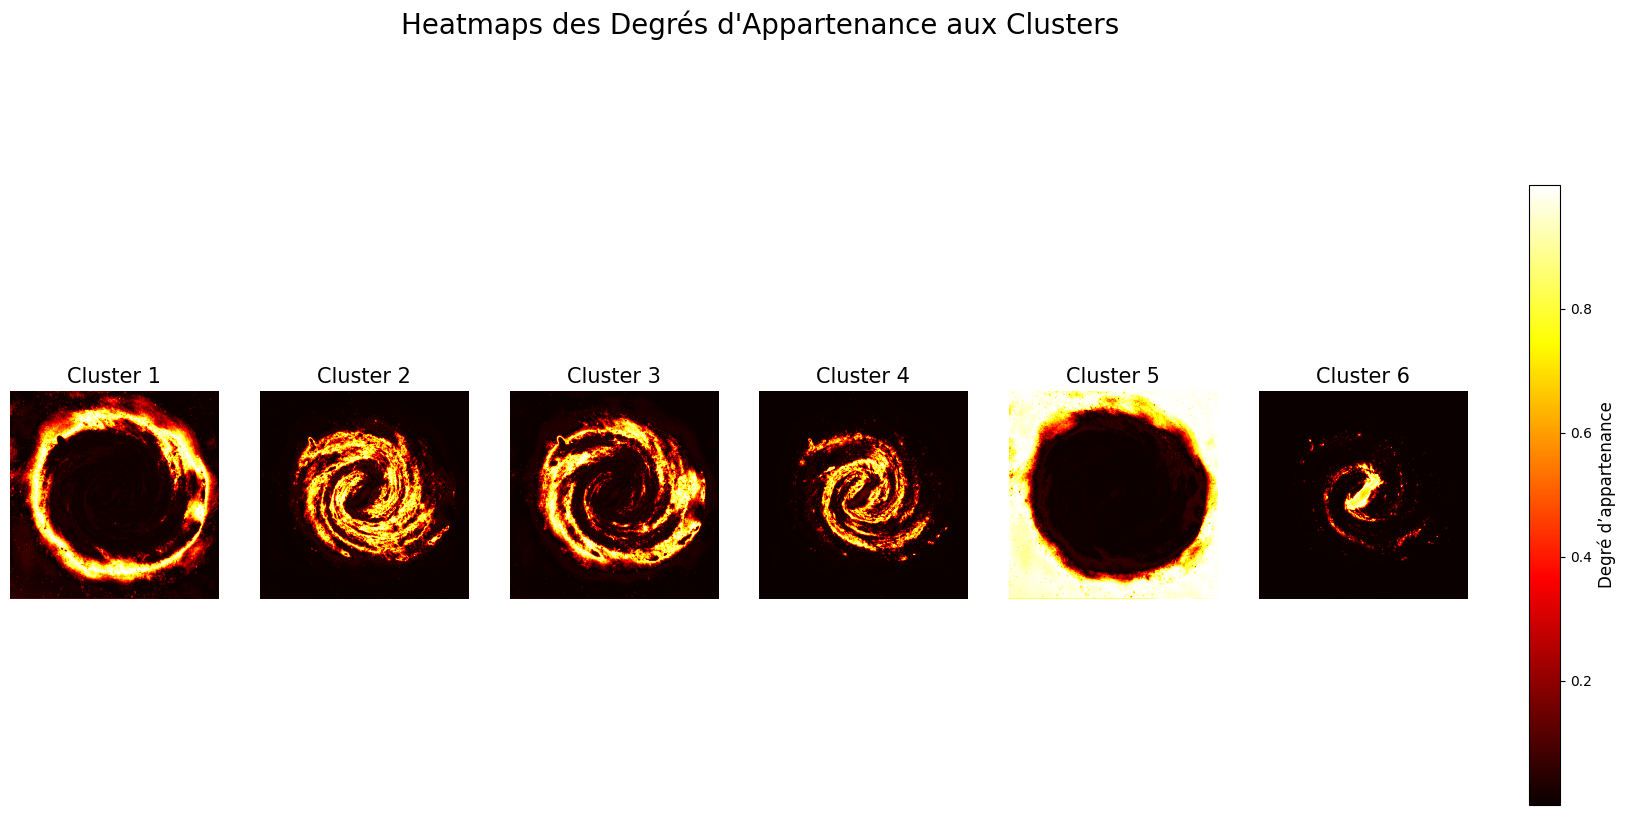

In [59]:
# Appel à la fonction pour afficher la carte de chaleur
display_heatmap(
    image=img_gray, 
    u_matrix=membership_matrix,
    num_clusters = 6
)

### RGB

In [ ]:
# Charger l'image RGB
img_color = cv2.imread('milky-way.jpg')
img_color = img_color / 255.0  # Normalisation entre 0 et 1

# Appliquer l'algorithme Fuzzy C-Means
centroids, membership_matrix = fuzzy_c_means_rgb(img_color, m=2, n_clusters=6)

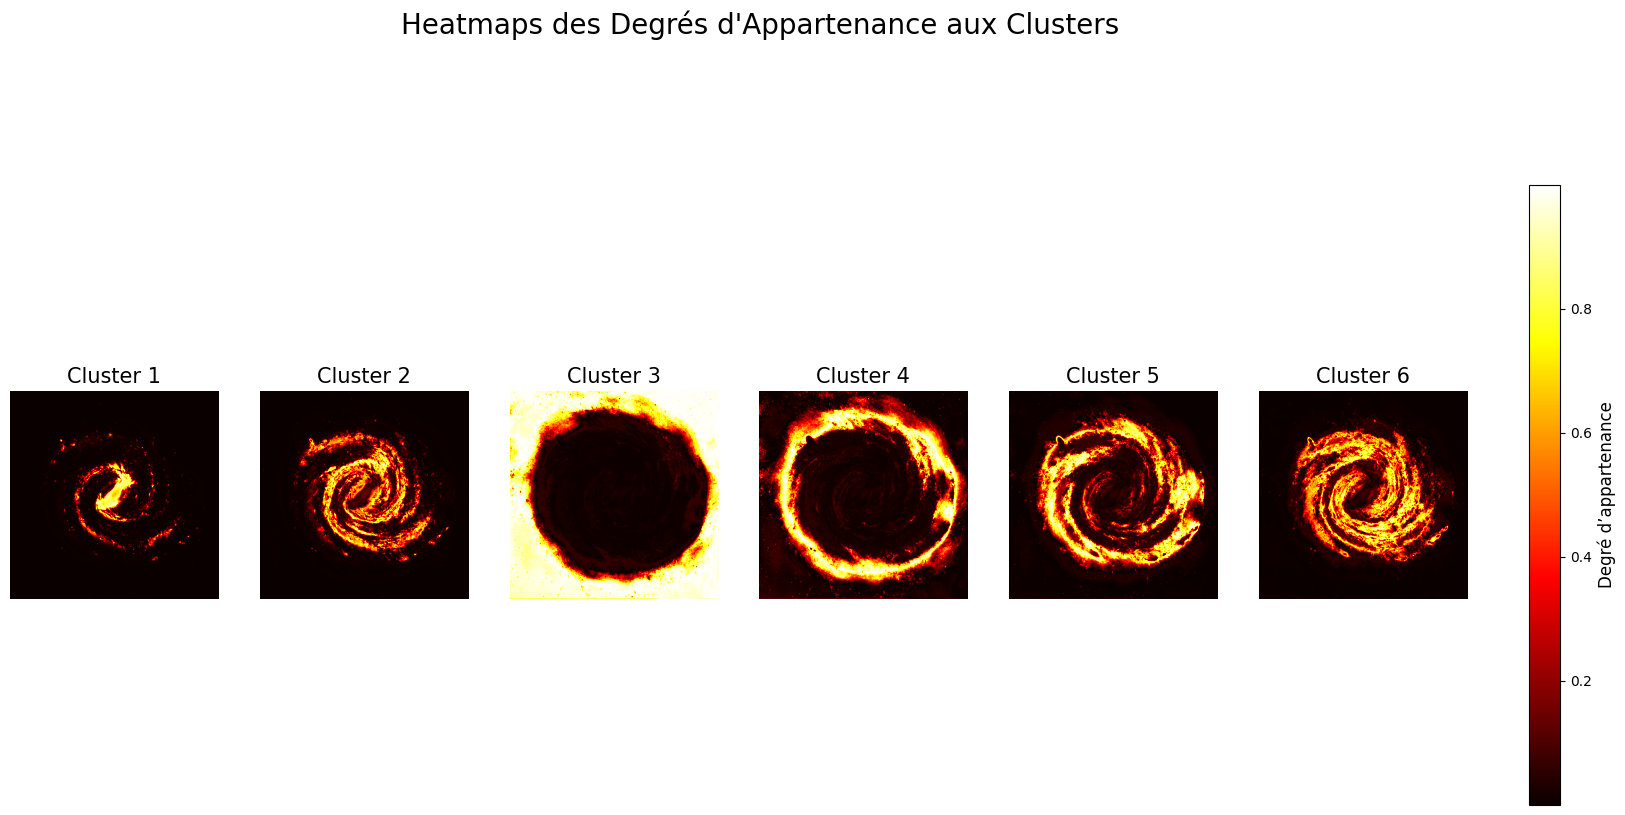

In [11]:
# Appel à la fonction pour afficher la carte de chaleur
display_heatmap(
    image=img_color, 
    u_matrix=membership_matrix,
    num_clusters = 6
)

# CAT (because cat is life)

In [17]:
# Charger l'image RGB
img_color = cv2.imread('Orange cat laying indoor.jpg')
img_color = img_color / 255.0  # Normalisation entre 0 et 1

# Appliquer l'algorithme Fuzzy C-Means
centroids, membership_matrix = fuzzy_c_means_rgb(img_color, m=2, n_clusters=2)
# Appliquer l'algorithme Fuzzy C-Means
centroids_10, membership_matrix_10 = fuzzy_c_means_rgb(img_color, m=10, n_clusters=2)
# Appliquer l'algorithme Fuzzy C-Means
centroids_30, membership_matrix_30 = fuzzy_c_means_rgb(img_color, m=30, n_clusters=2)

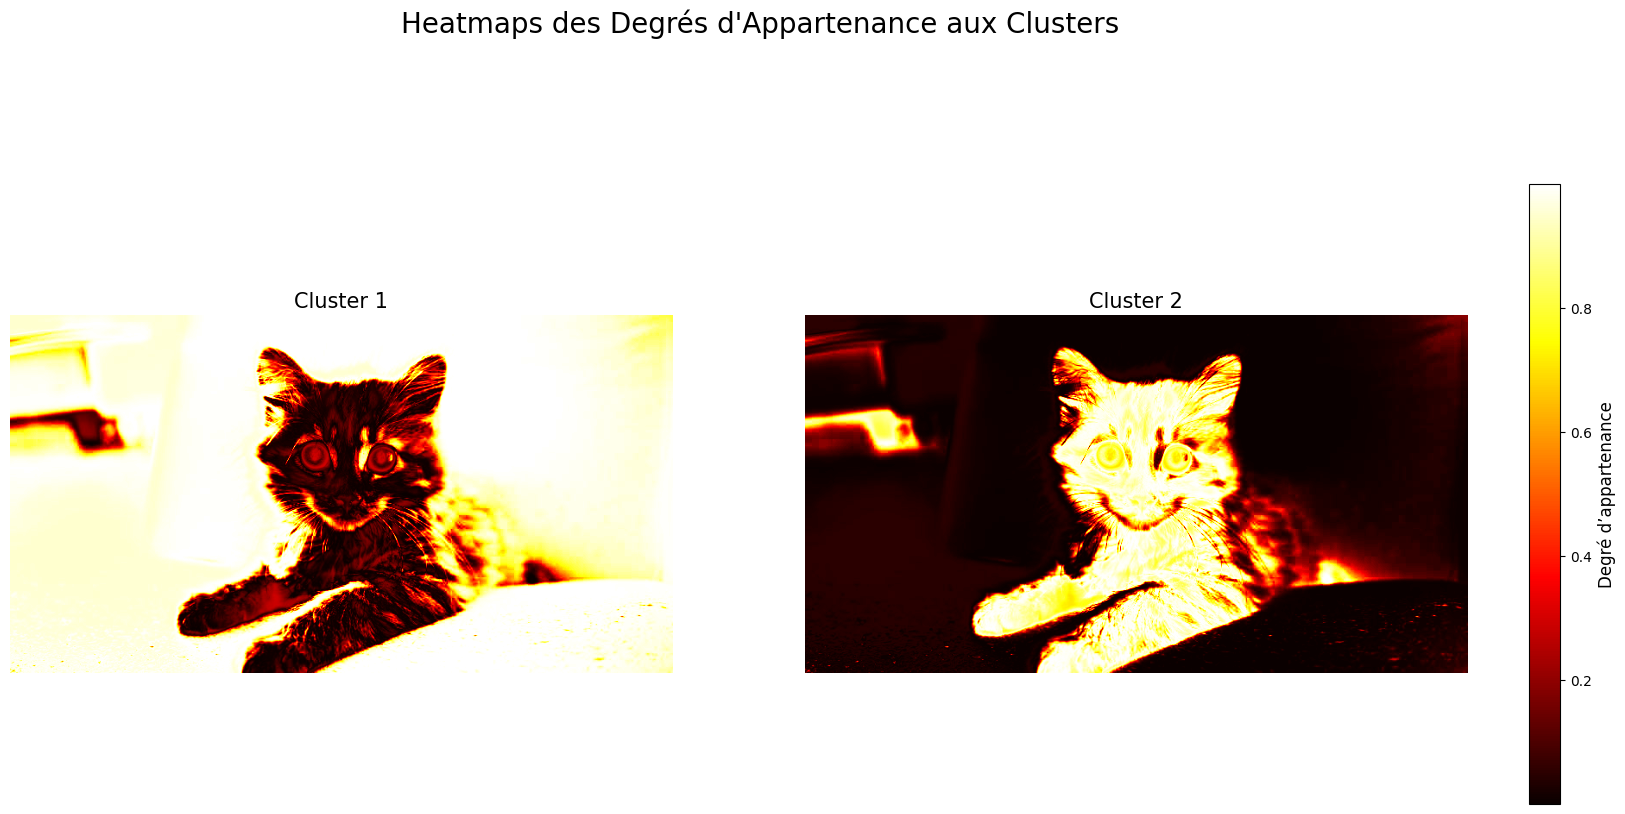

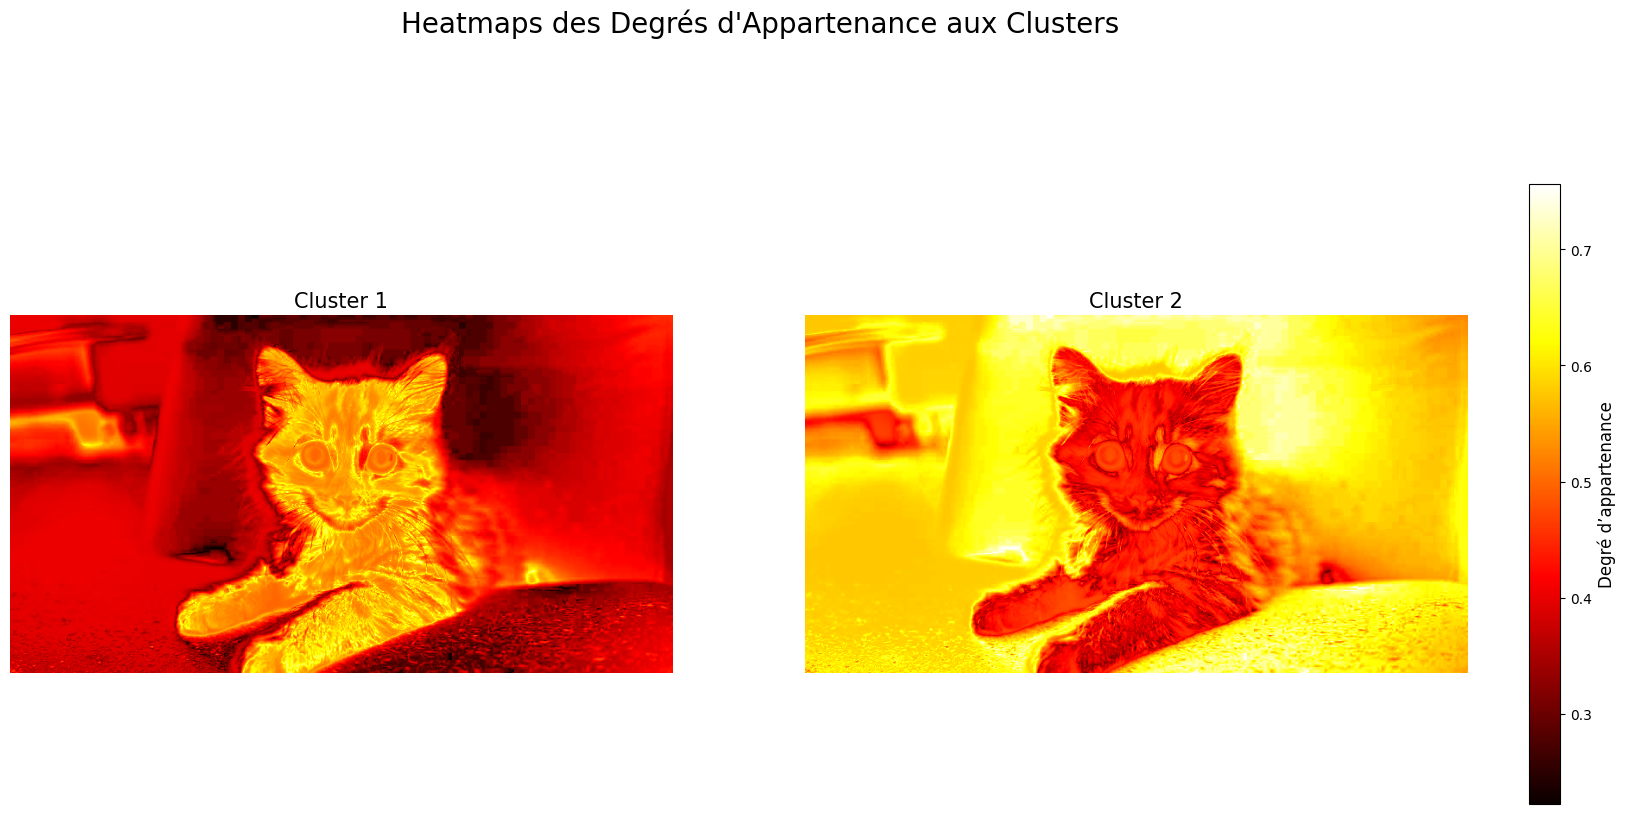

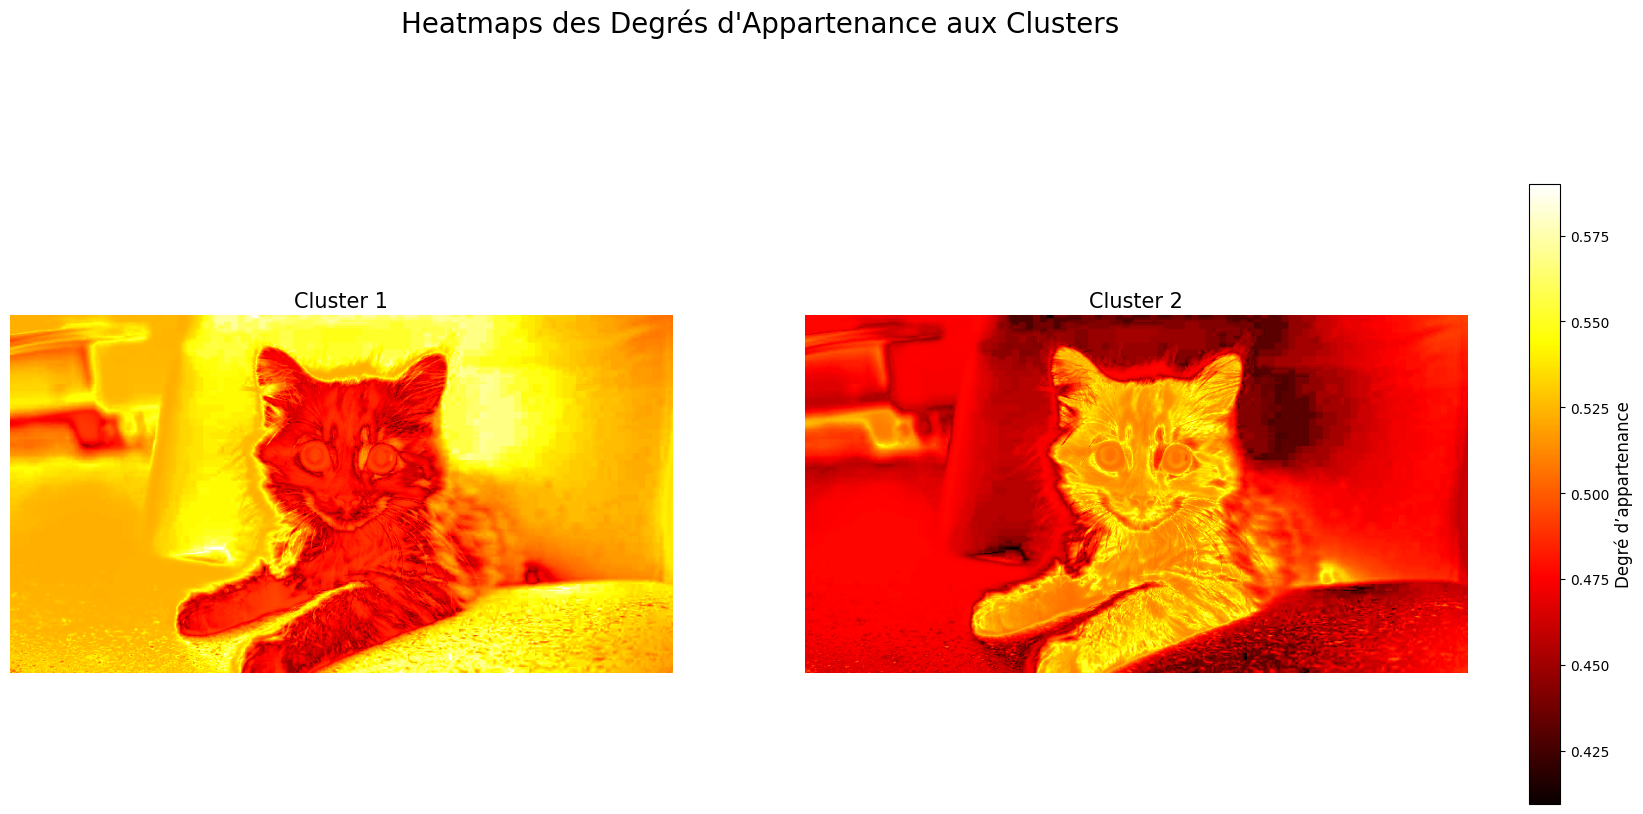

In [18]:
# Appel à la fonction pour afficher la carte de chaleur
display_heatmap(
    image=img_color, 
    u_matrix=membership_matrix,
    num_clusters = 2
)

# Appel à la fonction pour afficher la carte de chaleur
display_heatmap(
    image=img_color, 
    u_matrix=membership_matrix_10,
    num_clusters = 2
)

# Appel à la fonction pour afficher la carte de chaleur
display_heatmap(
    image=img_color, 
    u_matrix=membership_matrix_30,
    num_clusters = 2
)